In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('bankData.csv')
df.drop(labels=['campaign','pdays','previous','contact','day','month'],axis = 1, inplace=True)

df = pd.get_dummies(df)


df.head()


,age,balance,duration,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,housing_no,housing_yes,loan_no,loan_yes,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_no,y_yes
0,58,2143,261,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,1,1,0
1,44,29,151,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
2,33,2,76,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,1,0
3,47,1506,92,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
4,33,1,198,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,1,0


In [3]:
X_and_Y = df.values
np.random.shuffle(X_and_Y)
X = X_and_Y[:,1:]
Y = X_and_Y[:,0]

print(X.shape)
print(Y.shape)

(45211, 33)
(45211,)


In [4]:
#establish training and test data in 20/50/80 partition

#1 = 0.2
#2 = 0.5
#3 = 0.8

X_train1 = X[:int(0.2*len(X))]
X_test1 = X[int(0.2*len(X)):]

Y_train1 = Y[:int(0.2*len(Y))]
Y_test1 = Y[int(0.2*len(Y)):]

print(X_train1.shape, X_test1.shape, Y_train1.shape, Y_test1.shape)


X_train2 = X[:int(0.5*len(X))]
X_test2 = X[int(0.5*len(X)):]

Y_train2 = Y[:int(0.5*len(Y))]
Y_test2 = Y[int(0.5*len(Y)):]

print(X_train2.shape, X_test2.shape, Y_train2.shape, Y_test2.shape)


X_train3 = X[:int(0.8*len(X))]
X_test3 = X[int(0.8*len(X)):]

Y_train3 = Y[:int(0.8*len(Y))]
Y_test3 = Y[int(0.8*len(Y)):]

print(X_train3.shape, X_test3.shape, Y_train3.shape, Y_test3.shape)

(9042, 33) (36169, 33) (9042,) (36169,)
(22605, 33) (22606, 33) (22605,) (22606,)
(36168, 33) (9043, 33) (36168,) (9043,)


In [5]:
def heatmap(training_acc, gamma, C_list):
    plt.figure(figsize = (1,5))
    ax = sns.heatmap(data = training_acc, annot = True, fmt = '.3f', xticklabels = len(C_list), yticklabels = C_list, robust = True)
    ax.collections[0].colorbar.set_label("Accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title('Training Accuracy w.r.t $C$ and $\gamma$')
    plt.show()

In [6]:
#knn classifier using train/test #1

def knn(X_train,Y_train,X_test,Y_test):
    
    
    K_list = [1,2,3,4,5,6,7,8,9,10]     #10 features in data
        
    clf = GridSearchCV(KNeighborsClassifier(), iid= False, param_grid = {'n_neighbors':K_list}, cv = 5, return_train_score = True)
    clf.fit(X_train,Y_train)
    
    heatmap(clf.cv_results_['mean_train_score'].reshape(10,1), 'KNN Training Accuracy', K_list)
    
    opt_k = clf.best_params_['n_neighbors']
    
    clf_test = KNeighborsClassifier(n_neighbors=opt_k)
    clf_test.fit(X_train,Y_train)
    
    knn_accuracy = clf_test.score(X_test,Y_test)
    training_acc = clf.cv_results_['mean_test_score']
    for x,y in enumerate(K_list):
        if y == opt_k:
            opt_training_acc = training_acc[x]
            
    return knn_accuracy, opt_training_acc, opt_k

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


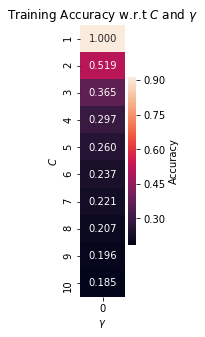

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


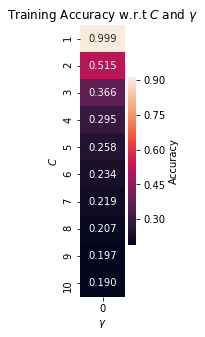

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


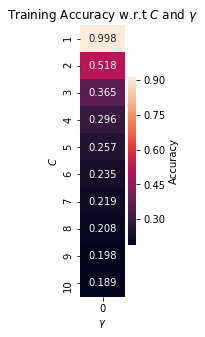

In [7]:
test_acc_KNN1,best_train_KNN1,C_KNN1 = knn(X_train1,Y_train1,X_test1,Y_test1)
test_acc_KNN2,best_train_KNN2,C_KNN2 = knn(X_train2,Y_train2,X_test2,Y_test2)
test_acc_KNN3,best_train_KNN3,C_KNN3 = knn(X_train3,Y_train3,X_test3,Y_test3)

In [8]:
def decisionTree(X_train,Y_train,X_test,Y_test):
    D_list = [1,2,3,4,5,6,7,8,9,10]
    
    clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy'),cv=5,iid = False, param_grid = {'max_depth':D_list}, return_train_score = True)
    clf.fit(X_train,Y_train)
    heatmap(clf.cv_results_['mean_train_score'].reshape(10,1),'Decision Tree Training Accuracy', D_list)
    
    opt_D = clf.best_params_['max_depth']
    clf_test = DecisionTreeClassifier(max_depth=opt_D, criterion='entropy')
    
    clf_test.fit(X_train,Y_train)
    
    tree_accuracy = clf_test.score(X_test,Y_test)
    
    train_accuracy = clf.cv_results_['mean_train_score']
    
    for x,y in enumerate(D_list):
        if y == opt_D:
            best_train_accuracy = train_accuracy[x]
            
    return tree_accuracy, best_train_accuracy, opt_D

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


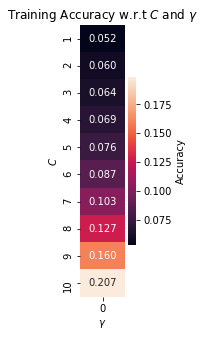

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


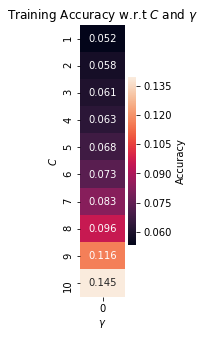

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


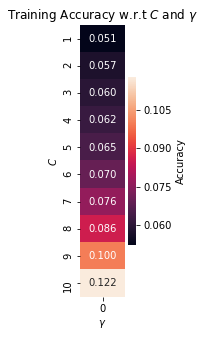

In [9]:
tree_acc1, tree_train_acc1, opt_D1 = decisionTree(X_train1,Y_train1,X_test1,Y_test1)
tree_acc2, tree_train_acc2, opt_D2 = decisionTree(X_train2,Y_train2,X_test2,Y_test2)
tree_acc3, tree_train_acc3, opt_D3 = decisionTree(X_train3,Y_train3,X_test3,Y_test3)

In [10]:
def svm(X_train,Y_train,X_test,Y_test):
    #C_list = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1,10]
    C_list = [1,2,3,4,5,6,7,8,9,10]
    gamma_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    svc = SVC(C= C_list, kernel = 'linear')
    clf = GridSearchCV(svc, cv=5, iid=False, param_grid={'C':C_list}, return_train_score = True)

    
    #clf = GridSearchCV(LinearSVC(max_iter = 1000000), cv=5, iid=False, param_grid={'C':C_list}, return_train_score = True)
    
    clf.fit(X_train,Y_train)
    
    train_accuracy = clf.cv_results_['mean_train_score']
    heatmap(train_accuracy.reshape(10,1), 'SVM Training Accuracy', C_list)
    opt_C = clf.best_params_['C']
    clf_test = SVC(C = opt_C, kernel='linear')
    
    clf_test.fit(X_train,Y_train)
    
    svm_accuracy = clf_test.score(X_test,Y_test)
    train_accuracy = clf.cv_results_['mean_train_score']
    
    for x,y in enumerate(C_list):
        if y == opt_C:
            best_train_accuracy = train_accuracy[x]
            
    return svm_accuracy, best_train_accuracy, opt_C

In [42]:
def randomForest(X_train,Y_train,X_test,Y_test):
    
    rf_list = np.arange(1,7)
    
    param_grid = {'max_depth':rf_list, 'n_estimators':[1, 2, 3, 4, 5, 6, 7]}
    rf = RandomForestClassifier(criterion = 'entropy')
    
    clf = GridSearchCV(rf, param_grid= param_grid, cv = 5, iid = False, return_train_score = True)
    
    clf.fit(X_train,Y_train)
    train_accuracy = clf.cv_results_['mean_train_score']
    
    heatmap(train_accuracy.reshape(42,1), 'RF Train Acc', C_list = rf_list)
    opt_rf = clf.best_params_['max_depth']
    
    clf_test = RandomForestClassifier(max_depth = opt_rf, criterion = 'entropy')
    
    clf_test.fit(X_train,Y_train)
    
    rf_accuracy = clf_test.score(X_test,Y_test)
    
    train_accuracy = clf.cv_results_['mean_train_score']

    for x,y in enumerate(rf_list):
        if y == opt_rf:
            best_train_accuracy = train_accuracy[x]
            
    return rf_accuracy, best_train_accuracy, opt_rf
    

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


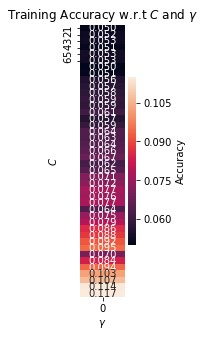

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\baria\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


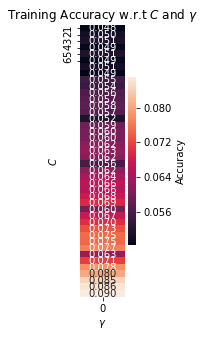

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\baria\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


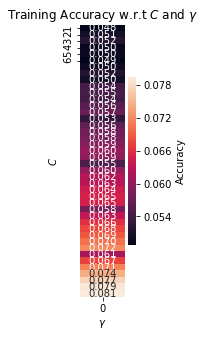

C:\Users\baria\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [43]:
rf_acc1, rf_train_acc1, opt_rf1 = randomForest(X_train1,Y_train1,X_test1,Y_test1)
rf_acc2, rf_train_acc2, opt_rf2 = randomForest(X_train2,Y_train2,X_test2,Y_test2)
rf_acc3, rf_train_acc3, opt_rf3 = randomForest(X_train3,Y_train3,X_test3,Y_test3)

In [44]:
d = {'Classifier Accuracy':[test_acc_KNN1,test_acc_KNN2,test_acc_KNN3,tree_acc1,tree_acc2,tree_acc3,rf_acc1,rf_acc2,rf_acc3],
     'Best Training Accuracy':[best_train_KNN1,best_train_KNN2,best_train_KNN3,tree_train_acc1,tree_train_acc2,tree_train_acc3,rf_train_acc1,rf_train_acc2,rf_train_acc3],
     'Optimal Feature':[C_KNN1,C_KNN2,C_KNN3,opt_D1,opt_D2,opt_D3,opt_rf1,opt_rf2,opt_rf3]}

results = pd.DataFrame(data = d)

In [46]:
#results.index = {'KNN 20/80','KNN 50/50', 'KNN 80/20', 'Decision Tree 20/80', 'Decision Tree 50/50', 'Decision Tree 80/20', 'SVM 20/80', 'SVM 50/50', 'SVM 80/20'}

results.rename(index={0:'KNN 20/80'},inplace=True)
results.rename(index={1:'KNN 50/50'},inplace=True)
results.rename(index={2:'KNN 80/20'},inplace=True)

results.rename(index={3:'Decision Tree 20/80'},inplace=True)
results.rename(index={4:'Decision Tree 50/50'},inplace=True)
results.rename(index={5:'Decision Tree 80/20'},inplace=True)

results.rename(index={6:'Random Forest 20/80'},inplace=True)
results.rename(index={7:'Random Forest 50/50'},inplace=True)
results.rename(index={8:'Random Forest 80/20'},inplace=True)



In [47]:
results

,Classifier Accuracy,Best Training Accuracy,Optimal Feature
KNN 20/80,0.033150,0.035941,10
KNN 50/50,0.034593,0.036232,2
KNN 80/20,0.033175,0.034227,4
Decision Tree 20/80,0.058503,0.075785,5
Decision Tree 50/50,0.054145,0.082968,7
Decision Tree 80/20,0.057061,0.062230,4
Random Forest 20/80,0.058033,0.053422,5
Random Forest 50/50,0.057374,0.049117,6
Random Forest 80/20,0.063143,0.049828,5
